In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

In [ ]:
# Separate the individual stains from the IHC image
def color_separate(ihc_rgb):

    #Convert the RGB image to HED using the prebuilt skimage method
    ihc_hed = rgb2hed(ihc_rgb)
    
    # Create an RGB image for each of the separated stains
    #Convert them to ubyte for easy saving to drive as an image
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))

    #Optional fun exercise of combining H and DAB stains into a single image with fluorescence look
    
    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

# Cast the two channels into an RGB image, as the blue and green channels
#Convert to ubyte for easy saving as image to local drive
    zdh = img_as_ubyte(np.dstack((null, d, h))) #DAB in green and H in Blue

    return (ihc_h, ihc_e, ihc_d, zdh)

In [ ]:
ihc_rgb =io.imread("/HPV-MMab.jpg")
H,E,D,HD = color_separate(ihc_rgb)
#plt.imsave('images/H_img.jpg', H)
#plt.imsave('images/DAB_img.jpg', D)

Text(0.5, 1.0, 'ihc_rgb')

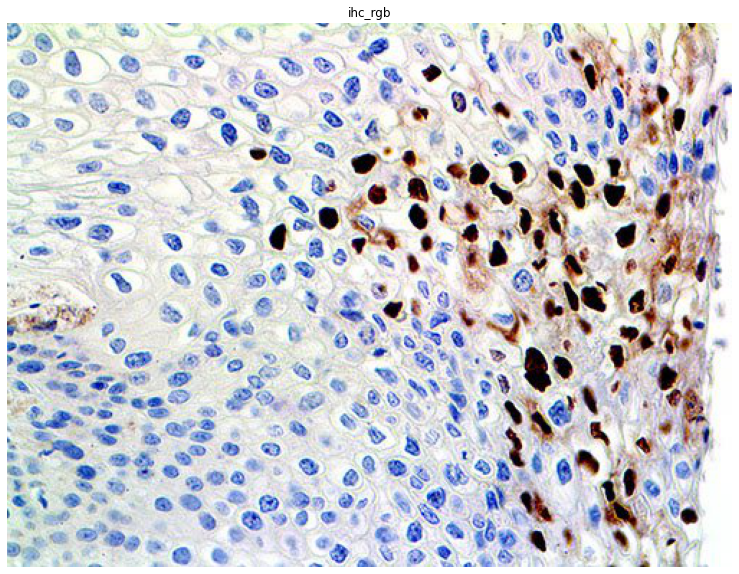

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,1,1)
plt.imshow(ihc_rgb)
plt.axis("off")
plt.title("ihc_rgb")

Text(0.5, 1.0, 'D image')

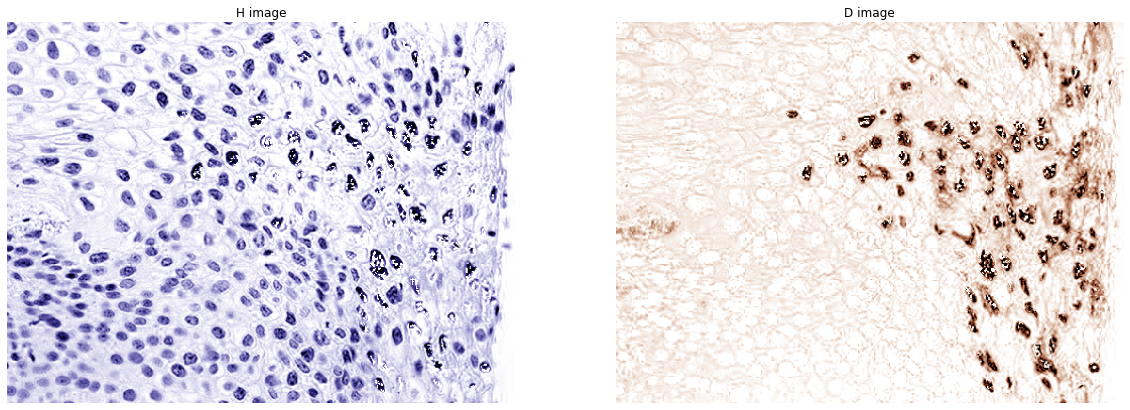

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(H)
plt.axis("off")
plt.title("H image")

plt.subplot(1,2,2)
plt.imshow(D)
plt.axis("off")
plt.title("D image")

In [ ]:
!pip install stardist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 5.2 MB/s 
     |████████████████████████████████| 69 kB 6.6 MB/s 
     |████████████████████████████████| 2.9 MB 38.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
from stardist.models import StarDist2D 
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

In [ ]:
# prints a list of available models 
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [ ]:
# Define a pretrained model to segment nuclei in fluorescence images (download from pretrained)
model = StarDist2D.from_pretrained('2D_demo')

Found model '2D_demo' for 'StarDist2D'.
5308416/5298331 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


Text(0.5, 1.0, 'D image')

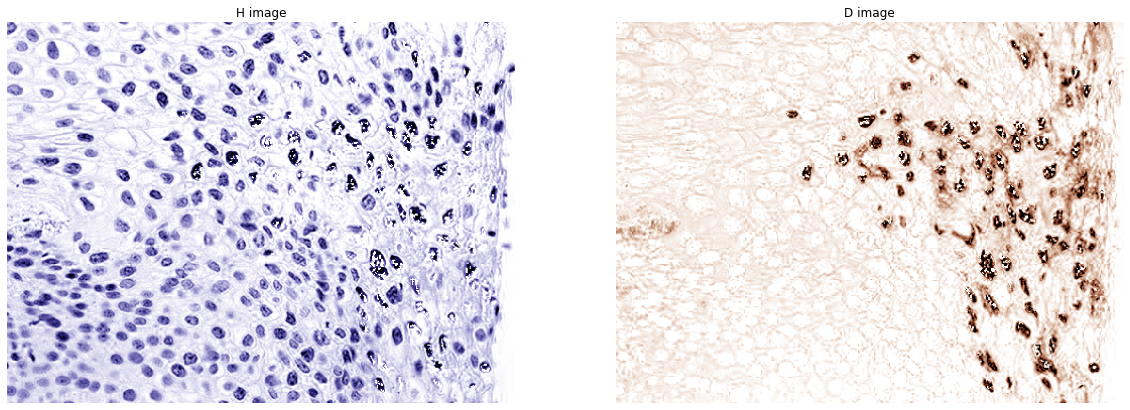

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(H)
plt.axis("off")
plt.title("H image")

plt.subplot(1,2,2)
plt.imshow(D)
plt.axis("off")
plt.title("D image")

Text(0.5, 1.0, 'DAB image')

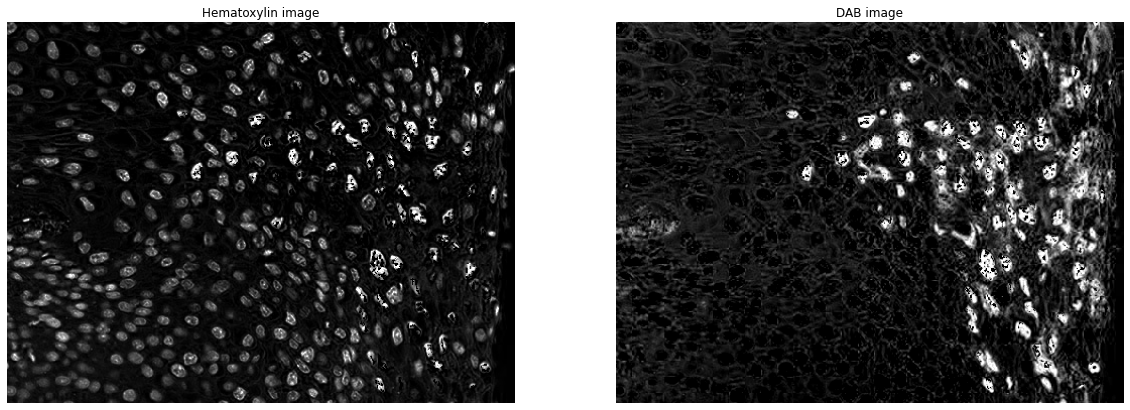

In [ ]:
H_img = np.invert(H[:,:,2])
D_img = np.invert(D[:,:,2])
#plt.imshow(D_img, cmap='gray')

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(H_img, cmap='gray')
plt.axis("off")
plt.title("Hematoxylin image")

plt.subplot(1,2,2)
plt.imshow(D_img, cmap='gray')
plt.axis("off")
plt.title("DAB image")

In [ ]:
D_labels, D_details = model.predict_instances(normalize(D_img))
H_labels, H_details = model.predict_instances(normalize(H_img))

Text(0.5, 1.0, 'DAB prediction + input overlay')

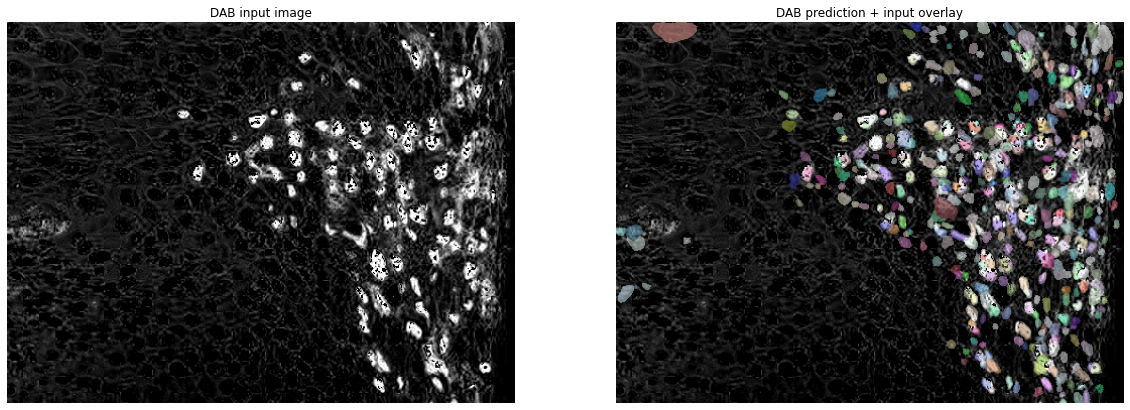

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(D_img, cmap="gray")
plt.axis("off")
plt.title("DAB input image")

plt.subplot(1,2,2)
plt.imshow(render_label(D_labels, img=D_img))
plt.axis("off")
plt.title("DAB prediction + input overlay")

Text(0.5, 1.0, 'Hematoxylin prediction + input overlay')

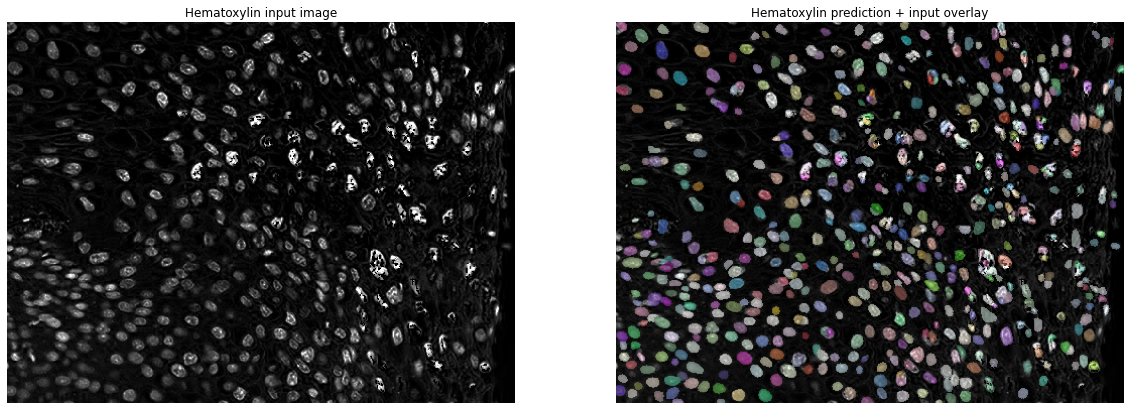

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(H_img, cmap="gray")
plt.axis("off")
plt.title("Hematoxylin input image")

plt.subplot(1,2,2)
plt.imshow(render_label(H_labels, img=H_img))
plt.axis("off")
plt.title("Hematoxylin prediction + input overlay")

In [ ]:
from skimage.measure import regionprops_table
import pandas as pd

In [ ]:
D_props = regionprops_table(D_labels, D_img, 
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])

D_analysis_results = pd.DataFrame(D_props)
print(D_analysis_results.head())

   label  area  equivalent_diameter  mean_intensity  solidity
0      1   162            14.361922      191.796296  0.941860
1      2   133            13.013103      181.842105  0.977941
2      3   163            14.406181      120.141104  0.964497
3      4   107            11.672045      178.355140  0.938596
4      5   143            13.493452      177.461538  0.922581


In [ ]:
H_props = regionprops_table(H_labels, H_img, 
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])

H_analysis_results = pd.DataFrame(H_props)
print(H_analysis_results.head())

   label  area  equivalent_diameter  mean_intensity  solidity
0      1   136            13.159049       58.522059  0.951049
1      2    91            10.764051       78.384615  0.968085
2      3   148            13.727325      100.743243  0.942675
3      4    71             9.507892       90.084507  0.922078
4      5    78             9.965575      109.705128  0.939759


In [ ]:
D_mean_analysis_results = D_analysis_results.mean(axis=0)
D_mean_analysis_results

label                  199.000000
area                    71.589421
equivalent_diameter      9.188018
mean_intensity          99.307114
solidity                 0.908967
dtype: float64

In [ ]:
H_mean_analysis_results = H_analysis_results.mean(axis=0)
H_mean_analysis_results

label                  295.500000
area                    70.047458
equivalent_diameter      9.203110
mean_intensity          72.481953
solidity                 0.926072
dtype: float64

In [ ]:
D_total_area = D_analysis_results["area"].sum()
H_total_area = H_analysis_results["area"].sum()
positivity = D_total_area / (D_total_area + H_total_area)
print("The DAB positivity is: ", positivity)

The DAB positivity is:  0.40747537599105366
